# A. Prepare Dataset

## Dataset Description
### This dataset is historical data of stock prices of a specific business. Here I chose Microsoft stock data (MSFT).

### Dataset columns:
* ***Date:*** The date on which the stock prices were recorded. This is typically in the format of YYYY-MM-DD.

* ***Open:*** The opening price is the price at which the stock first trades upon the opening of an exchange on a given trading day. It is often influenced by the previous day's close price and pre-market trading activity.

* ***High:*** The highest price at which the stock traded during the trading day. This figure represents the peak price of the stock during the trading hours.

* ***Low:*** The lowest price at which the stock traded during the trading day. This figure represents the lowest point the stock reached during the trading hours.

* ***Close:*** The closing price is the price at which the stock last traded at the end of the trading day. This price is commonly used as a benchmark for daily performance.

* ***Volume:*** The volume represents the total number of shares traded during the trading day. This figure indicates the level of activity and liquidity for the stock.

## Step 1: Crawl Stock Data from Nasdaq

In [ ]:
!pip install selenium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.7/475.7 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.4 MB/s eta 0:00:00


In [ ]:
!apt-get update

In [ ]:
!apt-get install -y chromium-browser

In [ ]:
!apt install chromium-chromedriver

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains

import pandas as pd

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--headless')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument('--disable-gpu')
user_agent = 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/33.0.1750.517 Safari/537.36'
chrome_options.add_argument('user-agent={0}'.format(user_agent))


In [ ]:
from selenium.common.exceptions import TimeoutException, NoSuchElementException, WebDriverException
import csv

driver = webdriver.Chrome(options=chrome_options)
driver.delete_all_cookies()

# URL của trang web
url = 'https://www.nasdaq.com/market-activity/stocks/MSFT/historical?page=1&rows_per_page=100&timeline=y10'
driver.get(url)
all_data = []
page_number = 1

def scrape_page(driver):
    rows = driver.find_elements(By.CSS_SELECTOR, '.table-row')
    data = []
    for row in rows:
        cells = row.find_elements(By.CSS_SELECTOR, '.table-cell')
        data.append([cell.text.strip() for cell in cells])
    return data

table_xpath = '//*[@class="simple-table-template table"]'

try:
    while True:
        print(f"Đang tải trang: {url}")
        driver.get(url)

        try:
            # Đợi trang tải xong và kiểm tra phần tử bảng có tồn tại
            WebDriverWait(driver, 20).until(
                EC.presence_of_element_located((By.XPATH, table_xpath))
            )
            print("Đã tìm thấy bảng.")
        except TimeoutException:
            print("Timeout: Element không tồn tại trong khoảng thời gian chờ.")
            break
        except NoSuchElementException:
            print("Element không tồn tại.")
            break
        except WebDriverException as e:
            print(f"Lỗi WebDriver: {e}")
            break

        page_data = scrape_page(driver)
        if not page_data:
            break
        all_data.extend(page_data)
        page_number += 1
        url = f'https://www.nasdaq.com/market-activity/stocks/aapl/historical?page={page_number}&rows_per_page=100&timeline=y10'
except Exception as e:
    print(f"Lỗi không xác định: {e}")
finally:
    driver.quit()

    with open('MSFT.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Date', 'Close', 'Volume', 'Open', 'High', 'Low'])
        writer.writerows(all_data)


## Step 1 - Plan B: Get dataset from endpoint

In [43]:
import json
import pandas as pd

def parse_to_csv(data):
    data = json.loads(data.decode('utf-8'))

    headers = data['data']['tradesTable']['headers']
    rows = data['data']['tradesTable']['rows']

    columns = list(headers.values())

    parsed_rows = []
    for row in rows:
        parsed_row = [
            row['date'],
            row['close'].replace('$', '').replace(',', ''),
            row['volume'].replace(',', ''),
            row['open'].replace('$', '').replace(',', ''),
            row['high'].replace('$', '').replace(',', ''),
            row['low'].replace('$', '').replace(',', '')
        ]
        parsed_rows.append(parsed_row)

    df = pd.DataFrame(parsed_rows, columns=columns)

    df.to_csv('MSFT.csv', index=False)

    return df

In [44]:
import requests

url = f'https://api.nasdaq.com/api/quote/MSFT/historical?assetclass=stocks&fromdate=2014-08-01&limit=1000000000'
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}
response = requests.get(url, headers=headers)
if response.status_code == 200:
    data = response.content
    df = parse_to_csv(data)
    df.rename(columns={"Close/Last": "Close"}, inplace=True)
else:
    print("Failed to retrieve data")


In [45]:
df

,Date,Close,Volume,Open,High,Low
0,08/05/2024,395.15,40709240,389.17,401.04,385.58
1,08/02/2024,408.49,29437900,412.49,415.00,404.34
2,08/01/2024,417.11,30296400,420.785,427.46,413.0901
3,07/31/2024,418.35,42891370,420.495,421.775,412.21
4,07/30/2024,422.92,32687580,427.72,429.05,417.36
...,...,...,...,...,...,...
2512,08/11/2014,43.20,19829060,43.26,43.45,43.02
2513,08/08/2014,43.20,28942570,43.23,43.315,42.91
2514,08/07/2014,43.23,30300560,42.84,43.45,42.65
2515,08/06/2014,42.74,24625300,42.74,43.17,42.21


## Step 2: EDA

### Step 2.1. Understand the dataset structure & Distinguish Attributes

In [46]:
# check dataframe shape
df.shape

(2517, 6)

In [47]:
df.isna().sum()

Date      0
Close     0
Volume    0
Open      0
High      0
Low       0
dtype: int64

In [48]:
# check data type of each column
df.dtypes

Date      object
Close     object
Volume    object
Open      object
High      object
Low       object
dtype: object

In [49]:
# convert data type from object to numerical values
from datetime import datetime

def into_unix_timestamp(raw_date):
    parsed_date = datetime.strptime(raw_date, "%m/%d/%Y")
    return int(datetime.timestamp(parsed_date))

df['Date'] = df['Date'].map(into_unix_timestamp)
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce').astype('Int64')
df['Open'] = pd.to_numeric(df['Open'], errors='coerce')
df['High'] = pd.to_numeric(df['High'], errors='coerce')
df['Low'] = pd.to_numeric(df['Low'], errors='coerce')

In [50]:
df.describe()

,Date,Close,Volume,Open,High,Low
count,2.517000e+03,2517.000000,2517.0,2517.000000,2517.000000,2517.000000
mean,1.564812e+09,172.220912,29297929.835121,172.167121,173.829962,170.433903
std,9.112381e+07,115.771444,13699751.550808,115.753696,116.812611,114.600897
min,1.407172e+09,40.290000,7425603.0,40.340000,40.740000,39.720000
25%,1.485968e+09,63.680000,21056000.0,63.950000,64.200000,63.450000
50%,1.564938e+09,136.620000,26233420.0,137.000000,137.760000,135.620000
75%,1.643648e+09,262.520000,33529070.0,261.660000,265.330000,259.070000
max,1.722791e+09,467.560000,202514100.0,467.000000,468.350000,464.460000


### Step 2.2. Univariate Analysis

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

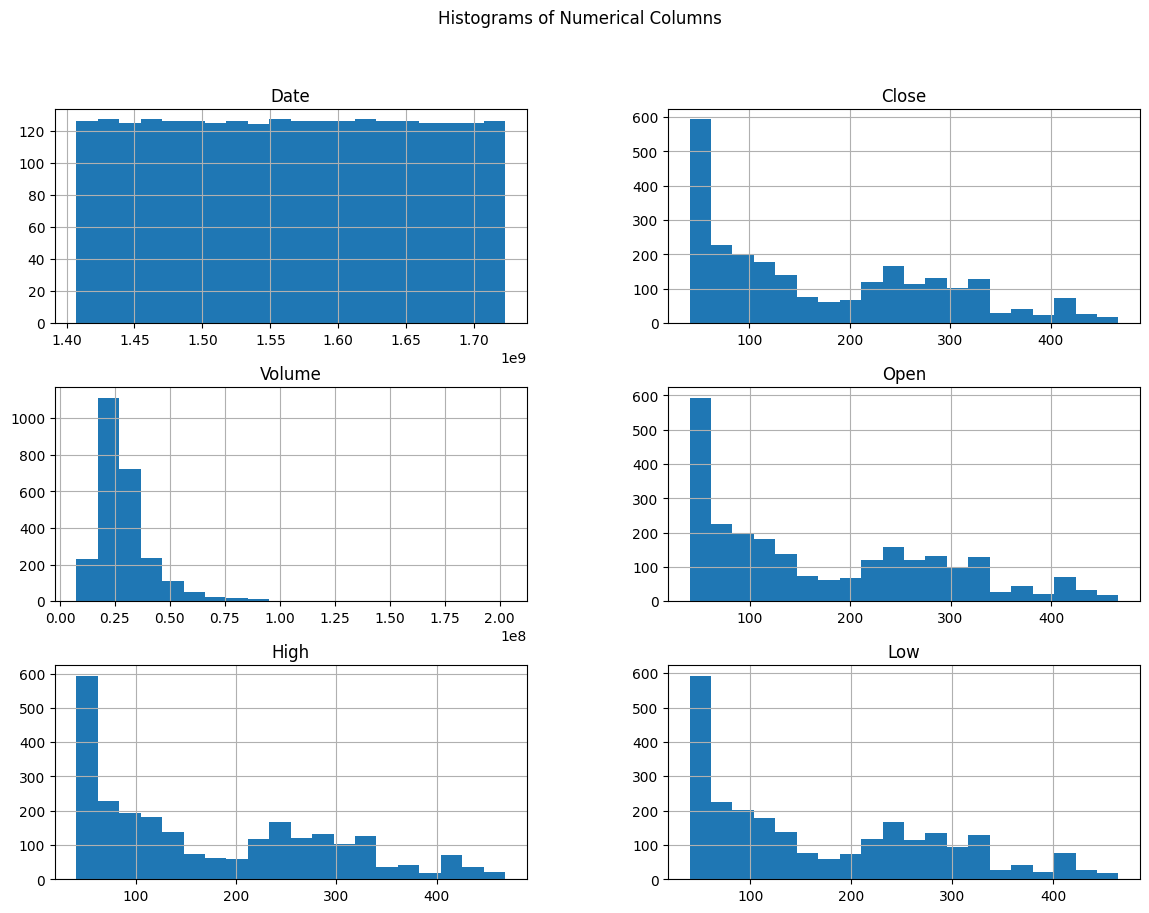

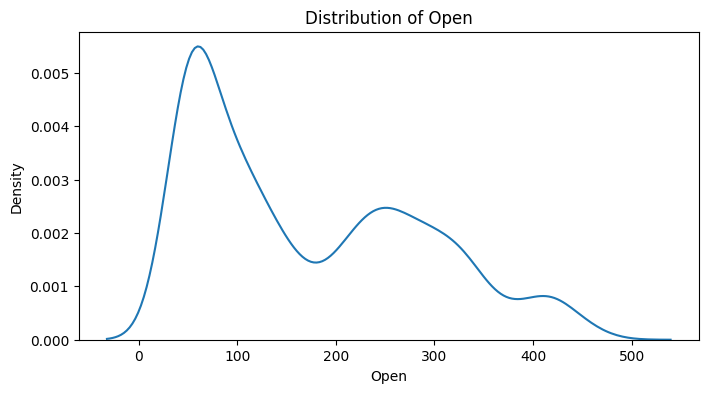

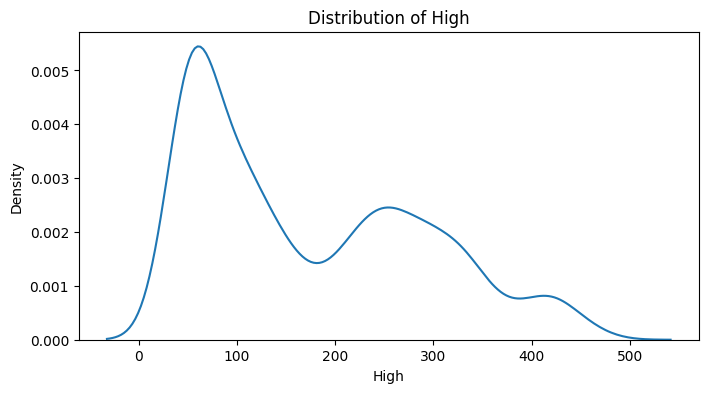

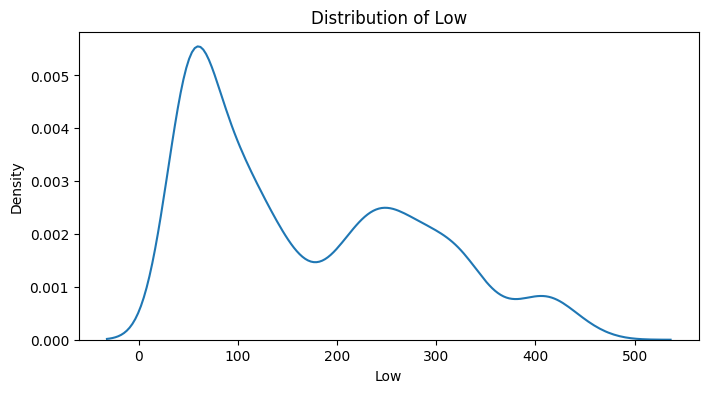

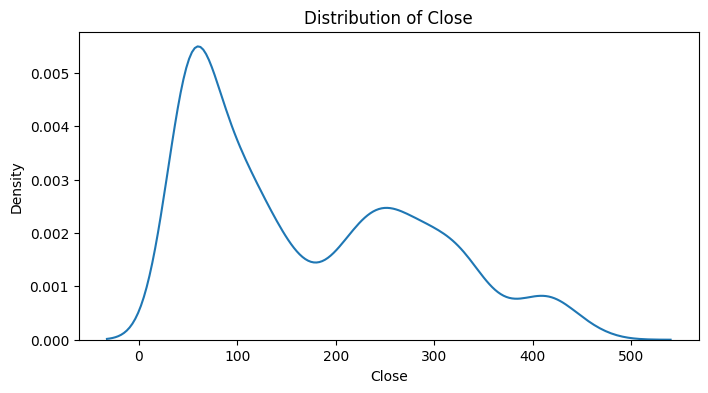

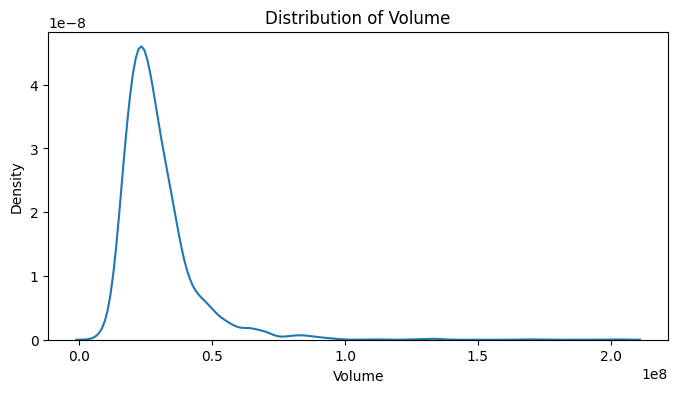

In [52]:
# Histograms
df.hist(bins=20, figsize=(14, 10))
plt.suptitle('Histograms of Numerical Columns')
plt.show()

for column in ['Open', 'High', 'Low', 'Close', 'Volume']:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(df[column])
    plt.title(f'Distribution of {column}')
    plt.show()

### Step 2.3. Bivariate Analysis

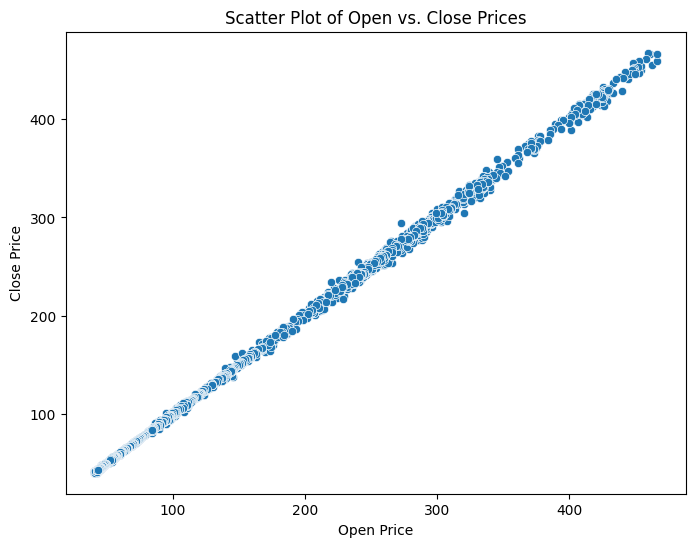

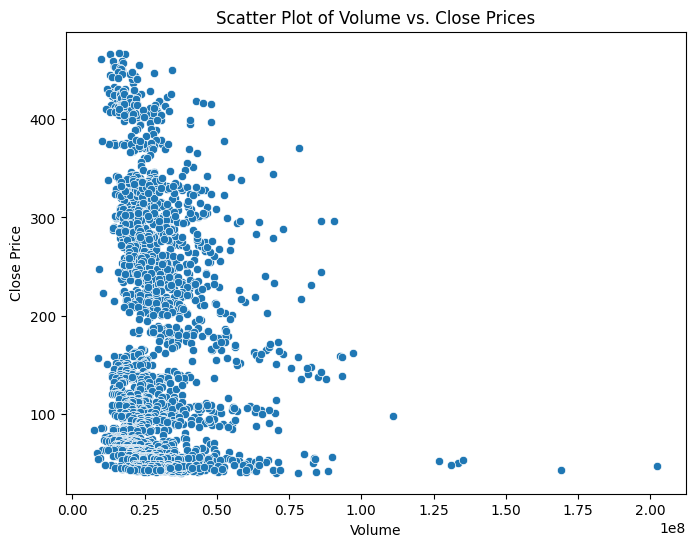

In [53]:
# Scatter plot between Open and Close prices
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Open', y='Close', data=df)
plt.title('Scatter Plot of Open vs. Close Prices')
plt.xlabel('Open Price')
plt.ylabel('Close Price')
plt.show()

# Scatter plot between Volume and Close prices
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Volume', y='Close', data=df)
plt.title('Scatter Plot of Volume vs. Close Prices')
plt.xlabel('Volume')
plt.ylabel('Close Price')
plt.show()


            Open      High       Low     Close    Volume
Open    1.000000  0.999882  0.999866  0.999715 -0.137499
High    0.999882  1.000000  0.999832  0.999858 -0.133042
Low     0.999866  0.999832  1.000000  0.999877 -0.142973
Close   0.999715  0.999858  0.999877  1.000000 -0.138637
Volume -0.137499 -0.133042 -0.142973 -0.138637  1.000000


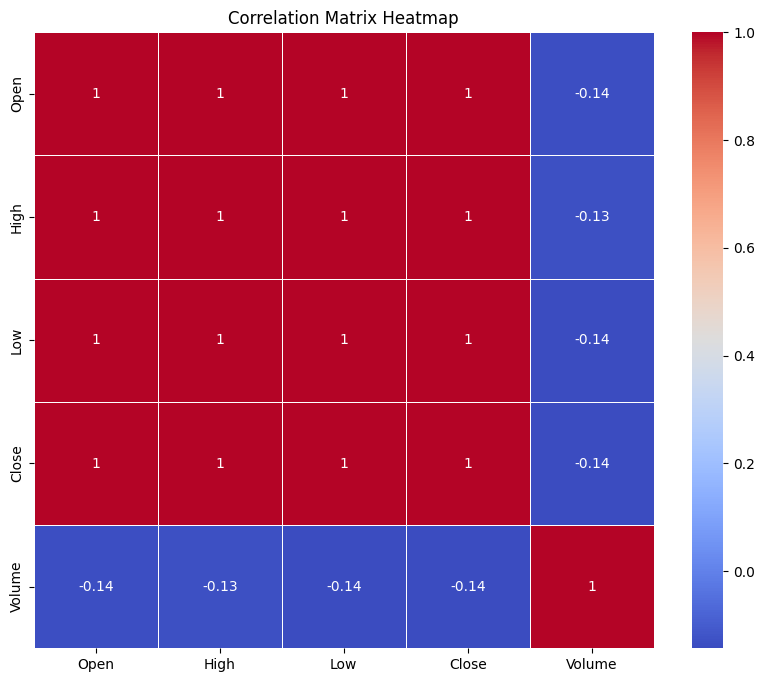

In [54]:
# Correlation matrix
corr_matrix = df[['Open', 'High', 'Low', 'Close', 'Volume']].corr()
print(corr_matrix)

# Heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()


### Step 2.4. Multivariate Statistics

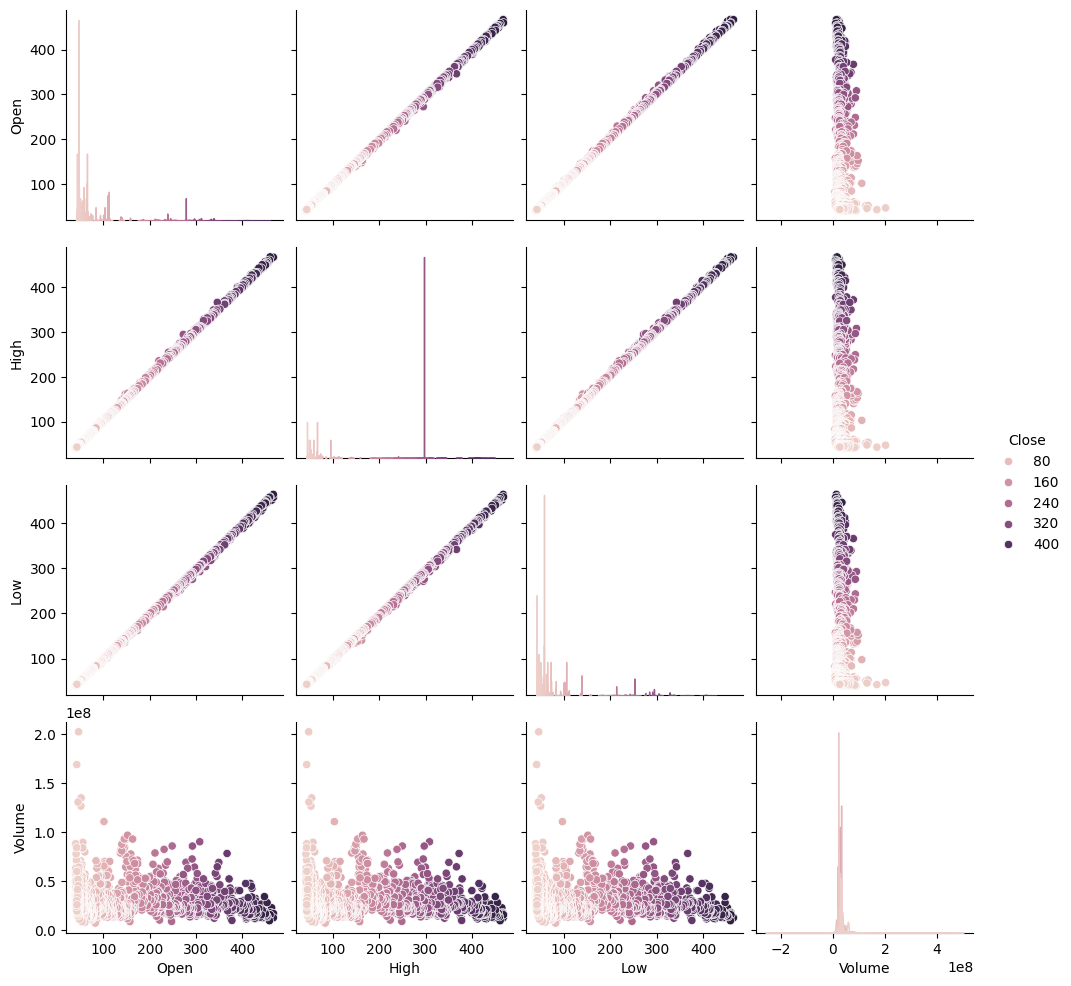

In [55]:
# Pairplot for selected features colored by target
sns.pairplot(df[['Open', 'High', 'Low', 'Close',  'Volume']], hue='Close')
plt.show()

### Step 2.5. Detect Abberant And Missing Values



In [56]:
df.isna().sum() # This stock dataset contains no missing values

Date      0
Close     0
Volume    0
Open      0
High      0
Low       0
dtype: int64

In [57]:
duplicate_rows = df.duplicated()
print(f"Number of duplicate rows: {duplicate_rows.sum()}")


Number of duplicate rows: 0


### Step 2.6. Detect Outliers



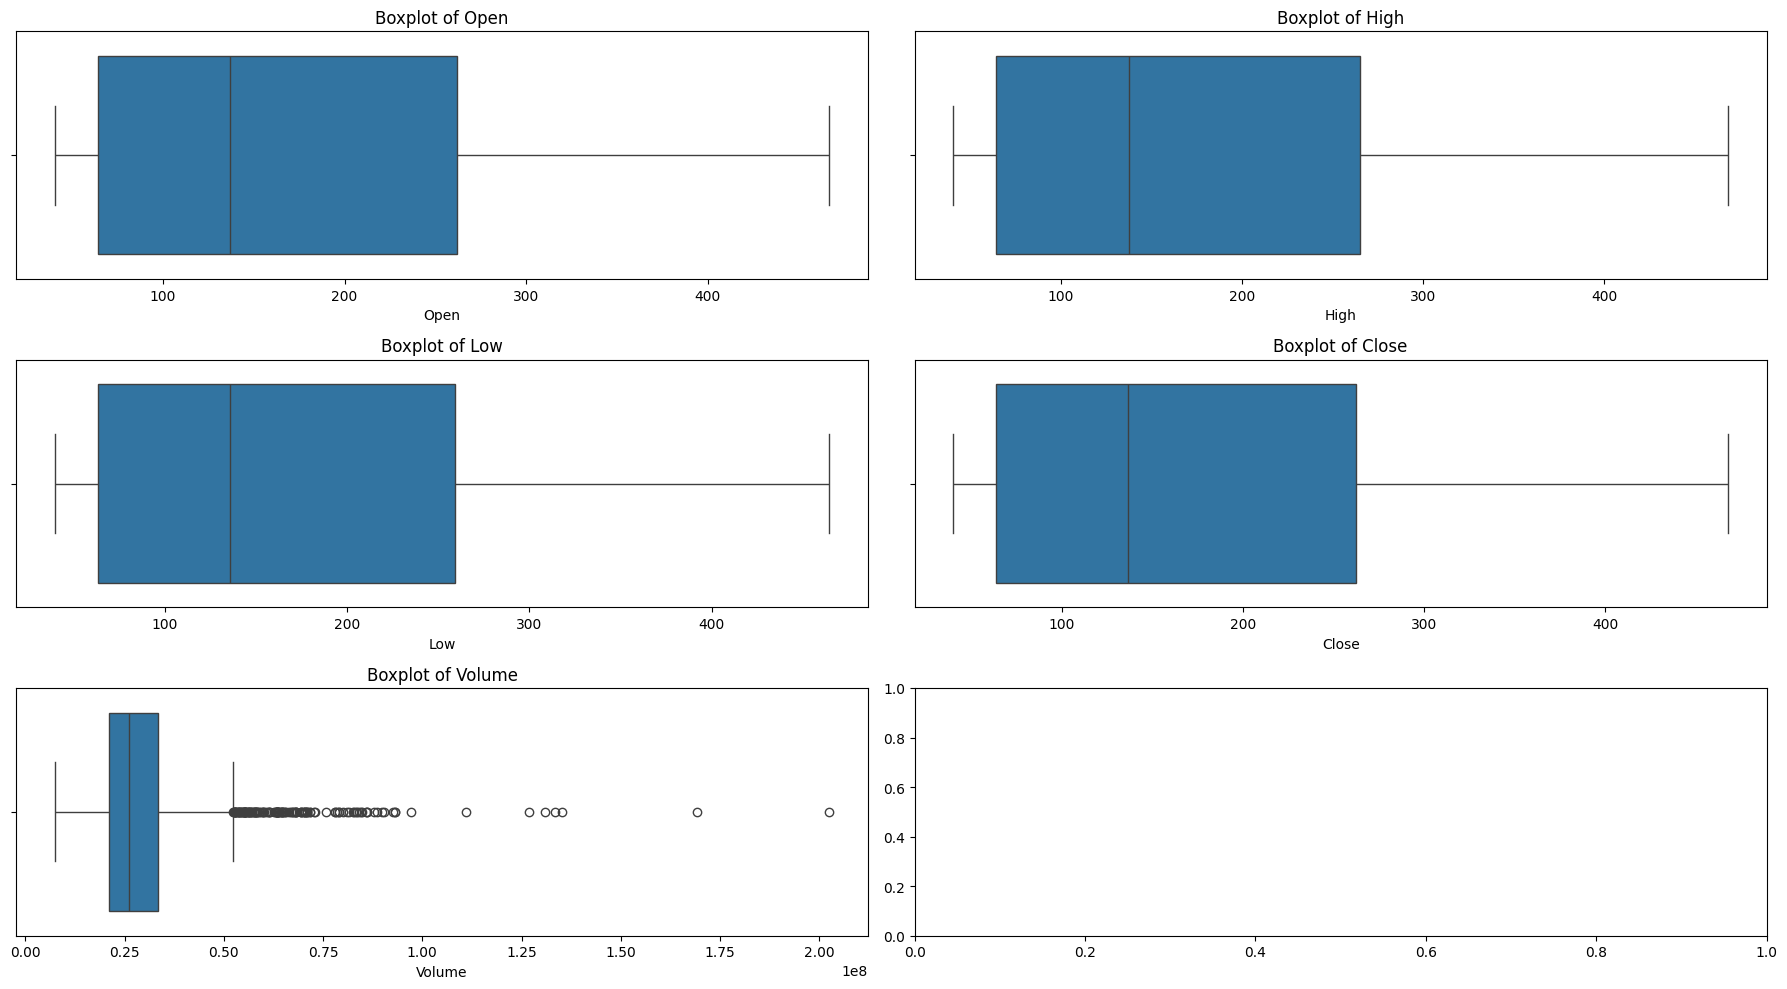

In [58]:
continuous_features = ['Open', 'High', 'Low', 'Close', 'Volume']

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 10))

for i, feature in enumerate(continuous_features):
    row = i // 2
    col = i % 2
    sns.boxplot(x=df[feature], ax=axes[row, col])
    axes[row, col].set_title(f'Boxplot of {feature}')
    axes[row, col].set_xlabel(feature)

plt.tight_layout()
plt.show()

Comment: Only volume has outliers

## Step 3. Cleaning Data

### Step 3.1. Handle missing values

In [ ]:
# no missing values

### Step 3.2. Handle outlier

In [ ]:
# from scipy.stats.mstats import winsorize

# # Apply winsorization
# df['Volume'] = winsorize(df['Volume'], limits=[0.05, 0.05])

## Step 4. Save data

In [59]:
df.to_csv("MSFT.csv")